In [1]:
import pkg_resources
if not any(list(map(lambda i: i.key == 'openeo', pkg_resources.working_set))):
    !pip install openeo

In [2]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import openeo
import holoviews as hv
import hvplot.xarray
import zarr



### Set up dask gateway 

In [3]:
from dask_gateway import Gateway
from dask_gateway.auth import BasicAuth
auth = BasicAuth(password="pangeo_dask")
#auth="jupyterhub"
gateway= Gateway(
    "http://api-daskhub-dask-gateway.daskhub:8000/",
    auth=auth,
)

In [4]:

cluster = gateway.new_cluster()
cluster.scale(4)
cluster

In [5]:
from distributed import Client
client=Client(cluster)
client

/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:1274: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| lz4     | 4.0.0  | None      | None    |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


<Client: 'tls://10.244.11.10:8786' processes=0 threads=0, memory=0 B>

In [6]:
POI_lat = 45.50 ; POI_lon = 9.36

#### Introduction to the Long Term statistics

In [7]:
#NDVI_LTS= xr.open_dataset(rf'.\data\CopernicusGlobalLand\LTS\c_gls_NDVI-LTS_1999-2019-0101_GLOBE_VGT-PROBAV_V3.0.1.nc')

import fsspec
filepath="https://object-store.cloud.muni.cz/swift/v1/foss4g-data/"

filename='CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0101_GLOBE_VGT-PROBAV_V3.0.1.nc'
f = fsspec.open(filepath+filename) 
NDVI_LTS = xr.open_dataset(f.open(), engine='h5netcdf',chunks={'time':-1, 'lat':'auto', 'lon':10000})
NDVI_LTS

<xarray.Dataset>
Dimensions:  (lon: 40320, lat: 15680)
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
Data variables:
    crs      |S1 ...
    min      (lat, lon) float32 dask.array<chunksize=(3136, 10000), meta=np.ndarray>
    median   (lat, lon) float32 dask.array<chunksize=(3136, 10000), meta=np.ndarray>
    max      (lat, lon) float32 dask.array<chunksize=(3136, 10000), meta=np.ndarray>
    mean     (lat, lon) float32 dask.array<chunksize=(3136, 10000), meta=np.ndarray>
    stdev    (lat, lon) float32 dask.array<chunksize=(3136, 10000), meta=np.ndarray>
    nobs     (lat, lon) float32 dask.array<chunksize=(3136, 10000), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    parent_identifier:    urn:cgls:global:ndvi_stats_all
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-0...
    long_name:            Normalized Difference Vegetation Index
    title:                Normalized Difference Vegetation Index: Long Term S...
    product_version:      V3.0.1
    ...                   ...
    source:               Derived from EO satellite imagery
    processing_mode:      Offline
    references:           https://land.copernicus.eu/global/products/ndvi
    copyright:            Copernicus Service information 2021
    archive_facility:     VITO
    history:              2021-03-01 - Processing line NDVI LTS

We can analyse dask graph, 

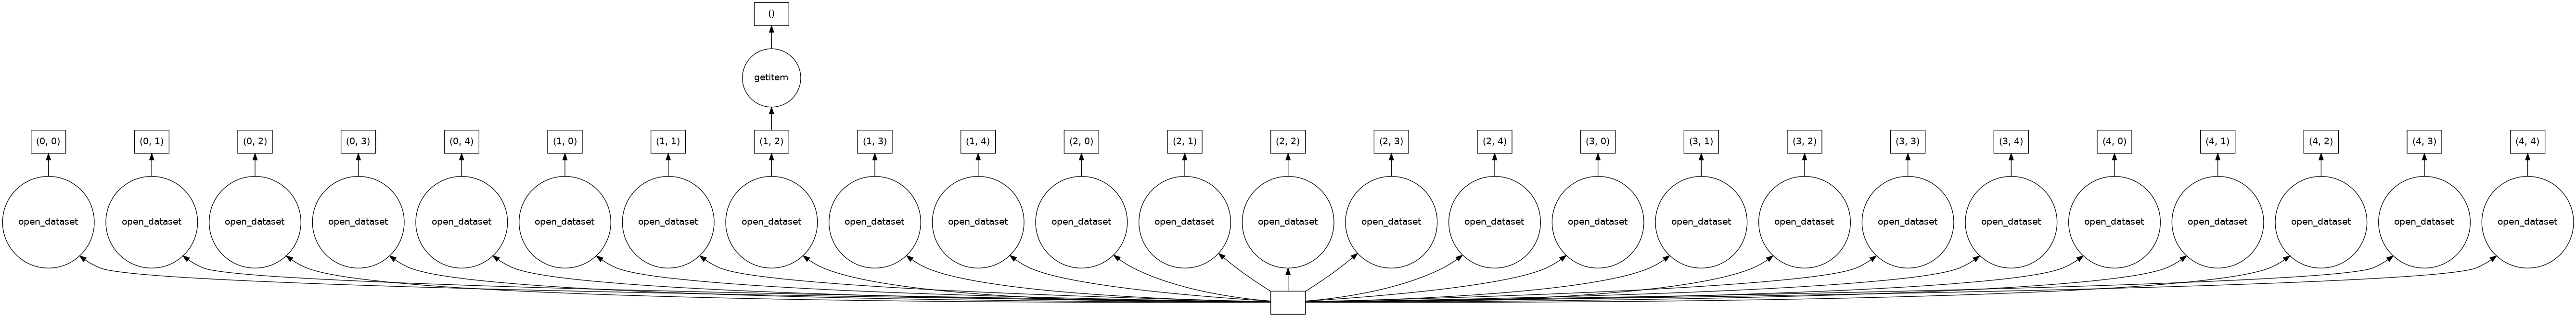

In [11]:
save=NDVI_LTS.sel(lat=POI_lat, lon=POI_lon, method='nearest')['min']
save.data.visualize()

dask workers are doing some useless reads of data.  We optimise, and verify the graph

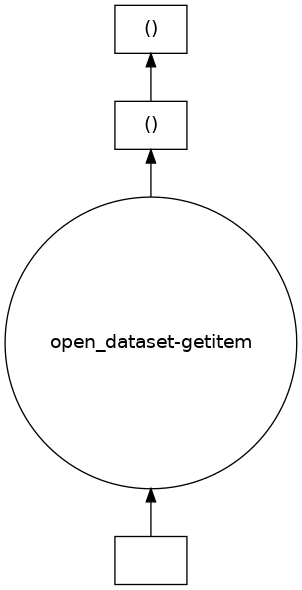

In [10]:
import dask
(save,)=dask.optimize(save)
save.data.visualize()

Compute the value

In [10]:
save.compute()

KilledWorker: ('original-open_dataset-74943c1c36d597ac62f7cd514aefd993min-d3e9b4d1bcc2b54f336be5b9206dcc61', <WorkerState 'tls://10.244.6.23:35295', name: dask-worker-e2eafbd3f7214ff1ad6d6bf00a4085be-65bgn, status: closed, memory: 0, processing: 1>)

### above line fails because there are missing pakcages in dask worker.  Next cell will install missing packages we need to for computation 

In [12]:
from distributed.diagnostics.plugin import PipInstall

extra_packages=["xarray","netCDF4","pooch","h5netcdf","odc-stac","zarr"]

plugin=PipInstall(extra_packages,restart=True)
client.register_worker_plugin(plugin)

{'tls://10.244.17.11:37037': {'status': 'OK'},
 'tls://10.244.5.16:38641': {'status': 'OK'},
 'tls://10.244.8.18:38601': {'status': 'OK'},
 'tls://10.244.9.20:37529': {'status': 'OK'}}

Verify the installation of package on dask worker

In [13]:
client.get_versions(packages=extra_packages,check=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:4239: UserWarning: Mismatched versions found

+----------+----------------+----------------+----------------+
| Package  | client         | scheduler      | workers        |
+----------+----------------+----------------+----------------+
| h5netcdf | 1.0.0          | None           | 1.0.2          |
| lz4      | 4.0.0          | None           | None           |
| netCDF4  | 1.5.8          | None           | 1.6.0          |
| pandas   | 1.4.2          | None           | 1.4.3          |
| python   | 3.9.13.final.0 | 3.10.5.final.0 | 3.10.5.final.0 |
| xarray   | 2022.3.0       | None           | 2022.6.0       |
| zarr     | 2.11.3         | None           | 2.12.0         |
+----------+----------------+----------------+----------------+
  warnings.warn(msg["warning"])


{'scheduler': {'host': {'python': '3.10.5.final.0',
   'python-bits': 64,
   'OS': 'Linux',
   'OS-release': '5.4.0-109-generic',
   'machine': 'x86_64',
   'processor': '',
   'byteorder': 'little',
   'LC_ALL': 'None',
   'LANG': 'C.UTF-8'},
  'packages': {'python': '3.10.5.final.0',
   'dask': '2022.6.0',
   'distributed': '2022.6.0',
   'msgpack': '1.0.4',
   'cloudpickle': '2.1.0',
   'tornado': '6.1',
   'toolz': '0.11.2',
   'numpy': '1.22.4',
   'pandas': None,
   'lz4': None,
   'xarray': None,
   'netCDF4': None,
   'pooch': None,
   'h5netcdf': None,
   'odc-stac': None,
   'zarr': None}},
 'workers': {'tls://10.244.17.11:42753': {'host': {'python': '3.10.5.final.0',
    'python-bits': 64,
    'OS': 'Linux',
    'OS-release': '5.4.0-109-generic',
    'machine': 'x86_64',
    'processor': '',
    'byteorder': 'little',
    'LC_ALL': 'None',
    'LANG': 'C.UTF-8'},
   'packages': {'python': '3.10.5.final.0',
    'dask': '2022.6.0',
    'distributed': '2022.6.0',
    'msgpack':

In [14]:
save.compute()

<xarray.DataArray 'min' ()>
array(0.108, dtype=float32)
Coordinates:
    lon      float64 9.357
    lat      float64 45.5
Attributes:
    standard_name:  normalized_difference_vegetation_index
    long_name:      Minimum Normalized Difference Vegetation Index over time ...
    grid_mapping:   crs
    flag_meanings:  sea no_data
    flag_values:    [254 255]
    units:          
    valid_range:    [  0 250]
    cell_methods:   area: mean time: minimum

Here we open full dataset using kerchunk catalogue. Notebook ../xx explains how this catalogue is made.  Using kerchunk, we can load Netcdf file stored on cloud, as 'zarr' format.  

In [ ]:
#LTS = xr.open_mfdataset(rf'.\data\CopernicusGlobalLand\LTS\*.nc', combine='nested', concat_dim=['time'], decode_coords="all")

In [15]:
catalogue="https://object-store.cloud.muni.cz/swift/v1/foss4g-catalogue/c_gls_NDVI-LTS_1999-2019.json"
LTS = xr.open_mfdataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo":catalogue
                    },
        "consolidated": False
    },
    #chunks={'time':-1, 'lat':'5MB', 'lon':'5MB'}
    
)
LTS

<xarray.Dataset>
Dimensions:  (lat: 15680, lon: 40320, time: 36)
Coordinates:
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) float64 nan 1.0 2.0 3.0 4.0 5.0 ... 31.0 32.0 33.0 34.0 35.0
Data variables:
    crs      object ...
    max      (time, lat, lon) float32 dask.array<chunksize=(1, 1207, 3102), meta=np.ndarray>
    mean     (time, lat, lon) float32 dask.array<chunksize=(1, 1207, 3102), meta=np.ndarray>
    median   (time, lat, lon) float32 dask.array<chunksize=(1, 1207, 3102), meta=np.ndarray>
    min      (time, lat, lon) float32 dask.array<chunksize=(1, 1207, 3102), meta=np.ndarray>
    nobs     (time, lat, lon) float32 dask.array<chunksize=(1, 1207, 3102), meta=np.ndarray>
    stdev    (time, lat, lon) float32 dask.array<chunksize=(1, 1207, 3102), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    archive_facility:     VITO
    copyright:            Copernicus Service information 2021
    history:              2021-03-01 - Processing line NDVI LTS
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-0...
    institution:          VITO NV
    ...                   ...
    references:           https://land.copernicus.eu/global/products/ndvi
    sensor:               VEGETATION-1, VEGETATION-2, VEGETATION
    source:               Derived from EO satellite imagery
    time_coverage_end:    2019-12-31T23:59:59Z
    time_coverage_start:  1999-01-01T00:00:00Z
    title:                Normalized Difference Vegetation Index: Long Term S...

In [16]:
#LTS = LTS.chunk({'time':-1, 'lat':'5MB', 'lon':'5MB'})
# chunk command is applied at open_mfdataset


LTS's 'time' dimention is not really a time.  We fix it here


In [17]:
dates_2022 = pd.date_range('20220101', '20221231')
decadie = dates_2022[np.isin(dates_2022.day, [1,11,21])]
LTS = LTS.assign_coords(time=decadie)

Note! If you use one of xarray’s open methods such as xarray.open_dataset to load netCDF files with the default engine, it is recommended to use decode_coords=”all”. This will load the grid mapping variable into coordinates for compatibility with rioxarray. From [rioxarray documentation](https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html#xarray)


In [18]:
LTS = LTS.rio.write_crs(4326)

 Lines from xarray_hands_on_1, to select dataset at 'Lombardia' and we compute the 'min' values at 'Lombardia' area

In [19]:
AOI_name = 'Lombardia'
GAUL = gpd.read_file('zip+https://mars.jrc.ec.europa.eu/asap/files/gaul1_asap.zip')
AOI_poly = GAUL[GAUL.name1 == AOI_name].geometry
AOI_min_lon, AOI_min_lat, AOI_max_lon, AOI_max_lat = AOI_poly.bounds.values.tolist()[0]


In [20]:
LTS = LTS.sel(lat=slice(AOI_max_lat,AOI_min_lat) ,lon=slice(AOI_min_lon,AOI_max_lon))
LTS = LTS.rio.clip(AOI_poly, crs=4326)
save=LTS.sel(lat=POI_lat, lon=POI_lon, method='nearest')['min']
save#.values

<xarray.DataArray 'min' (time: 36)>
dask.array<getitem, shape=(36,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 45.5
    lon      float64 9.357
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-12-21
    crs      int64 0
Attributes:
    cell_methods:   area: mean time: minimum
    flag_meanings:  sea no_data
    flag_values:    [254, 255]
    grid_mapping:   crs
    long_name:      Minimum Normalized Difference Vegetation Index over time ...
    standard_name:  normalized_difference_vegetation_index
    units:           
    valid_range:    [0, 250]

Before we 'compute' using dask, we verify the task count, and optimise it. 

In [21]:
import dask
(save,)=dask.optimize(save)
save.data#.visualize()

dask.array<getitem, shape=(36,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>

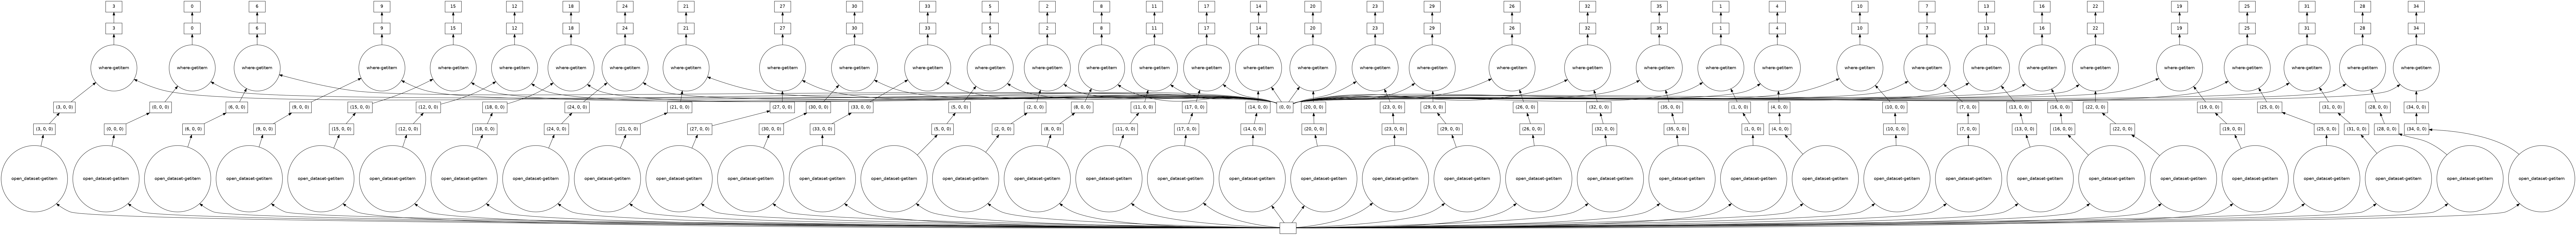

In [22]:
save.data.visualize()

In [23]:
save.compute()

<xarray.DataArray 'min' (time: 36)>
array([0.10800001, 0.10800001, 0.17600001, 0.16800001, 0.128     ,
       0.172     , 0.20800002, 0.216     , 0.26      , 0.32      ,
       0.33600003, 0.33600003, 0.34000003, 0.39200002, 0.36400002,
       0.30800003, 0.34400004, 0.37200004, 0.39600003, 0.42400002,
       0.51600003, 0.55200005, 0.55200005, 0.512     , 0.48000002,
       0.43600005, 0.384     , 0.37200004, 0.33200002, 0.268     ,
       0.30400002, 0.28800005, 0.28800005, 0.268     , 0.244     ,
       0.19200002], dtype=float32)
Coordinates:
    lat      float64 45.5
    lon      float64 9.357
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-12-21
    crs      int64 0
Attributes:
    cell_methods:   area: mean time: minimum
    flag_meanings:  sea no_data
    flag_values:    [254, 255]
    grid_mapping:   crs
    long_name:      Minimum Normalized Difference Vegetation Index over time ...
    standard_name:  normalized_difference_vegetation_index
    units:           
    valid_range:    [0, 250]

explainig zarr needs to be before loading catalogue, (to do later using other example) 

In [24]:
#LTS.to_zarr(rf'.\data\CopernicusGlobalLand\LTS\c_gls_NDVI-LTS_1999-2019-{AOI_name}_VGT-PROBAV_V3.zarr', mode='w', )

In [25]:
#LTS = xr.open_zarr(rf'.\data\CopernicusGlobalLand\LTS\c_gls_NDVI-LTS_1999-2019-{AOI_name}_VGT-PROBAV_V3.zarr')

In [26]:
LTS_NDVI_POI = LTS.sel(lat=POI_lat, lon=POI_lon, method='nearest')
POI_min = LTS_NDVI_POI['min']
POI_max = LTS_NDVI_POI['max']
POI_std = LTS_NDVI_POI['stdev']
POI_mean = LTS_NDVI_POI['mean']

In [27]:
POI = NDVI_AOI_interp.sel(lat=POI_lat, lon=POI_lon, method='nearest')

NameError: name 'NDVI_AOI_interp' is not defined

 Lines from xarray_hands_on_1, to select dataset at 'Lombardia' and we compute the 'min' values at 'Lombardia' areat

In [28]:
cgls_ds= xr.open_dataset(f'C_GLS_NDVI_20220101_20220701_{AOI_name}_S3_2.nc')
cgls_ds = cgls_ds.rename(x='lon', y='lat', t='time')
NDVI = cgls_ds.NDVI * (1/250) - 0.08
NDVI_msk = NDVI.where((NDVI >= -0.08) & (NDVI <= 0.92))
NDVI_msk = NDVI_msk.rio.write_crs(4326)
NDVI_AOI = NDVI_msk.rio.clip(AOI_poly, crs=4326)
NDVI_AOI_interp = NDVI_AOI.interpolate_na('time', method='linear', max_gap=pd.to_timedelta(31, 'd'))
NDVI_AOI_interp

<xarray.DataArray 'NDVI' (time: 20, lat: 657, lon: 984)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat          (lat) float64 46.63 46.63 46.63 46.62 ... 44.69 44.68 44.68
  * lon          (lon) float64 8.502 8.505 8.508 8.511 ... 11.42 11.42 11.43
  * time         (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-11
    spatial_ref  int64 0

In [29]:
POI = NDVI_AOI_interp.sel(lat=POI_lat, lon=POI_lon, method='nearest')

In [30]:
POI

<xarray.DataArray 'NDVI' (time: 20)>
array([0.36 , 0.508, 0.42 , 0.408, 0.452, 0.34 , 0.328, 0.532, 0.416,
       0.476, 0.48 , 0.64 , 0.58 , 0.384, 0.436, 0.492, 0.528, 0.36 ,
       0.532, 0.508])
Coordinates:
    lat          float64 45.5
    lon          float64 9.359
  * time         (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-11
    spatial_ref  int64 0

In [31]:
(POI.hvplot(width=1000, height=700, label='NDVI') *
 POI_mean.hvplot(c='grey', label='mean LTS 1999-2019', alpha=0.2, line_dash='dashed') *
 POI_min.hvplot(c='b',label='min LTS 1999-2019', alpha=0.2, line_dash='dashed') *
 POI_max.hvplot(c='r', label='Max LTS 1999-2019', alpha=0.2, line_dash='dashed') *
 hv.Area((POI_mean.time, POI_mean - POI_std, POI_mean + POI_std ), vdims=['- Std', '+ Std'], label='Standard deviation LTS 1999-2019',).opts( color='blue', alpha=0.2))\
    .opts(title=f"CGLS S3 300m NDVI fluctuation over the year 2022 in comparison with CGLS Long Term Statistics\nPoint of interest Lat {np.round(POI.lat.data,2)} Lon {np.round(POI.lon.data,2)}",
          legend_position='bottom_right')

:Overlay
   .Curve.NDVI                                         :Curve   [time]   (NDVI)
   .Curve.Mean_LTS_1999_hyphen_minus_2019              :Curve   [time]   (mean)
   .Curve.Min_LTS_1999_hyphen_minus_2019               :Curve   [time]   (min)
   .Curve.Max_LTS_1999_hyphen_minus_2019               :Curve   [time]   (max)
   .Area.Standard_deviation_LTS_1999_hyphen_minus_2019 :Area   [x]   (- Std,+ Std)

In [32]:
NDVI_AOI_interp = NDVI_AOI_interp.rio.write_crs(4326)
LTS = LTS.rio.write_crs(4326)

In [33]:
LTS = LTS.rio.clip(AOI_poly, crs=4326)

In [34]:
NDVI_1k = NDVI_AOI_interp.rio.reproject_match(LTS)

In [35]:
NDVI_1k.coords

Coordinates:
  * x            (x) float64 8.509 8.518 8.527 8.536 ... 11.39 11.4 11.41 11.42
  * y            (y) float64 46.63 46.63 46.62 46.61 ... 44.71 44.71 44.7 44.69
  * time         (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-11
    spatial_ref  int64 0

In [36]:
NDVI_1k = NDVI_1k.rename({'x': 'lon', 'y':'lat'})

In [37]:
NDVI_1k.coords

Coordinates:
  * lon          (lon) float64 8.509 8.518 8.527 8.536 ... 11.4 11.41 11.42
  * lat          (lat) float64 46.63 46.63 46.62 46.61 ... 44.71 44.7 44.69
  * time         (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-11
    spatial_ref  int64 0

In [38]:
NDVI_1k = NDVI_1k.where((NDVI_1k >= -0.08) & (NDVI_1k <= 0.92))

In [39]:
NDVI_1k.hvplot(groupby='time', cmap='RdYlGn', width=800, height=700)

:DynamicMap   [time]
   :Image   [lon,lat]   (NDVI)

In [40]:
VCI = ((NDVI_1k - LTS['min']) / (LTS['max'] - LTS['min'])) * 100

In [42]:
VCI.name = 'VCI'

In [41]:
VCI

<xarray.DataArray (time: 20, lat: 219, lon: 327)>
dask.array<mul, shape=(20, 219, 327), dtype=float64, chunksize=(1, 219, 327), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-11
  * lon          (lon) float64 8.509 8.518 8.527 8.536 ... 11.4 11.41 11.42
  * lat          (lat) float64 46.63 46.63 46.62 46.61 ... 44.71 44.7 44.69
    spatial_ref  int64 0
    crs          int64 0

We optimise the dask's tasks

In [44]:
(VCI,)=dask.optimize(VCI)
VCI

<xarray.DataArray 'VCI' (time: 20, lat: 219, lon: 327)>
dask.array<mul, shape=(20, 219, 327), dtype=float64, chunksize=(1, 219, 327), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-11
  * lon          (lon) float64 8.509 8.518 8.527 8.536 ... 11.4 11.41 11.42
  * lat          (lat) float64 46.63 46.63 46.62 46.61 ... 44.71 44.7 44.69
    spatial_ref  int64 0
    crs          int64 0

## below crashs but even with dask local cluster it does, so probably something to do with data zone? (later) 

In [45]:
VCI.isel(time=4).hvplot()

KilledWorker: ("('nanmin_skip-_nanmin_skip-aggregate-c7cf86d1bc0baa2541b8f39be90ef001',)", <WorkerState 'tls://10.244.8.18:44465', name: dask-worker-363b1ac3740643a6879cb4791d3f7761-p9rc7, status: closed, memory: 0, processing: 2>)

:Image   [lon,lat]   (VCI)

In [ ]:
VCI.sel(lat=POI_lat, lon=POI_lon, method='nearest').hvplot.hist()

In [ ]:
VCI.plot()

In [ ]:
VCI.isel(time=-1).hvplot.contourf(cmap='RdYlGn', alpha=0.7,
                                  levels=[-200,-100,-50, 0,50,100,200],
                                  geo=True, tiles= 'CartoLight',
                                  width=800, height=700,
                                  title=f'CGLS VCI {AOI_name} {VCI.isel(time=-1).time.dt.date.data}')

In [ ]:
cluster.shutdown()

### Execise: Using the Global Land Cover mask all the urban areas

In [ ]:
session.describe_collection('GLOBAL_LAND_COVER')

In [ ]:
datacube_LC = session.load_collection(
    'GLOBAL_LAND_COVER',
    spatial_extent={"west": AOI_min_lon, "south":AOI_min_lat , "east": AOI_max_lon, "north":AOI_max_lat },
    bands=['Discrete_Classification_map']
)

In [ ]:
datacube_LC.download(f"C_GLS_LC_20220101_20220701_{AOI_name}_PROBA_3.nc", format="NetCDF")

In [ ]:
cgls_LC= xr.open_dataset('C_GLS_LC_20220101_20220701_CENTRALITALY_3.nc')

In [ ]:
LC_2019 = cgls_LC.Discrete_Classification_map.sel(t='2019-01-01')

In [ ]:
LC_2019 = LC_2019.rio.write_crs(4326)

In [ ]:
LC_2019 = LC_2019.rio.reproject_match(LTS)

In [ ]:
LC_2019

In [ ]:
urban_mask = xr.where(LC_2019 == 50, False, True).rename({'x': 'lon', 'y':'lat'})

In [ ]:
urban_mask.hvplot(width=800, height=700)

In [ ]:
VCI_masked = VCI.where(urban_mask) 

In [ ]:
VCI_masked.name = 'VCI masked'

In [ ]:
VCI_masked.isel(time=0).hvplot(cmap='RdYlGn', alpha=0.7,
                                  geo=True, tiles= 'CartoLight',
                                  width=800, height=700,)